# Handwritten digit recognition using Convolutional Neural Nets
___

About MNIST data - (http://yann.lecun.com/exdb/mnist/)

We will be using MNIST data to train our digit recognizer. The data is nothing but collection of a bunch of images assembled together for the very purpose of training Machine Learning models to recognize digits.

## Import required libraries

In [1]:
import pandas as pd # data manipulation
import random # generating random numbers
import numpy as np # optimized numeric calculations
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting

# keras for training neural nets
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
%matplotlib inline

Using Theano backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import cv2
from sklearn.externals import joblib
from scipy import ndimage

## MNIST data is part of datasets available with Keras

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data() # will download the data if running for first time

In [5]:
print X_train.shape, y_train.shape, X_test.shape, y_test.shape

(60000L, 28L, 28L) (60000L,) (10000L, 28L, 28L) (10000L,)


## Lets see some of the images we have in our data

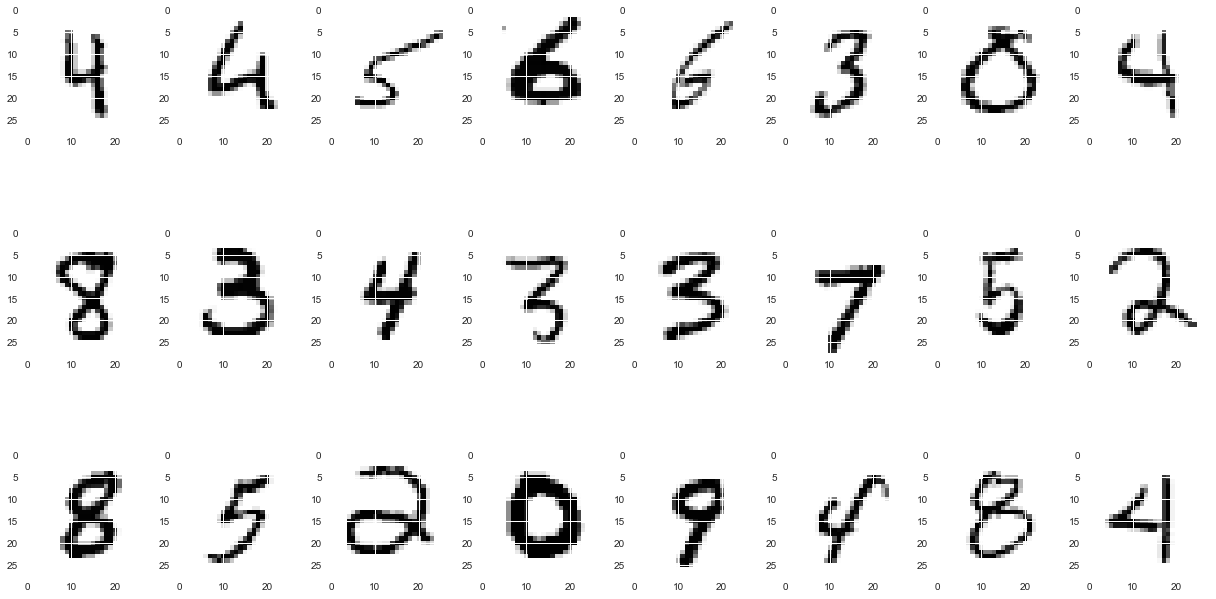

In [6]:
plt.figure(figsize=(17, 10))
for i in range(24):
    plt.subplot(3, 8, i+1)
    plt.imshow(X_train[random.randint(1, X_train.shape[0])])
plt.tight_layout()

## Also, check the distribution of target class; We don't want unbalanced data

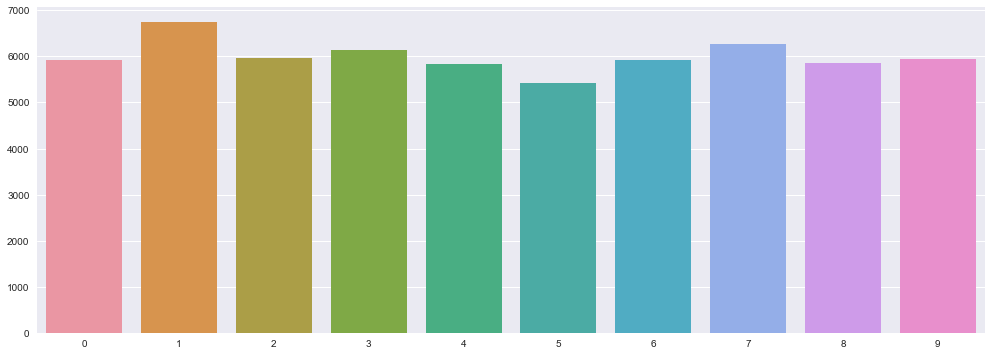

In [7]:
temp = pd.Series(y_train).value_counts()
plt.figure(figsize=(17, 6))
sns.barplot(temp.index, temp.values);

## We need to create a Tensor of our data so that we can feed it to CNN

In [8]:
# reshape to be [samples][channels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

In [9]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [10]:
# normalize inputs from 0-255 to 0-1; always a good idea in any Machine learning model
X_train = X_train/255
X_test = X_test/255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [11]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [20]:
model = baseline_model()
# # Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=32, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
262s - loss: 0.1579 - acc: 0.9532 - val_loss: 0.0643 - val_acc: 0.9813
Epoch 2/2
268s - loss: 0.0590 - acc: 0.9818 - val_loss: 0.0481 - val_acc: 0.9855


## Set path to save the model weights
This location should also have folder called imgs with images to be categorized.

In [21]:
path = 'C:/Users/utsav/Documents/lol numbers/'

In [22]:
model.save(path+'model.h5')

In [23]:
model.load_weights(path+'model.h5')

## Read image from path/img folder and predict digits

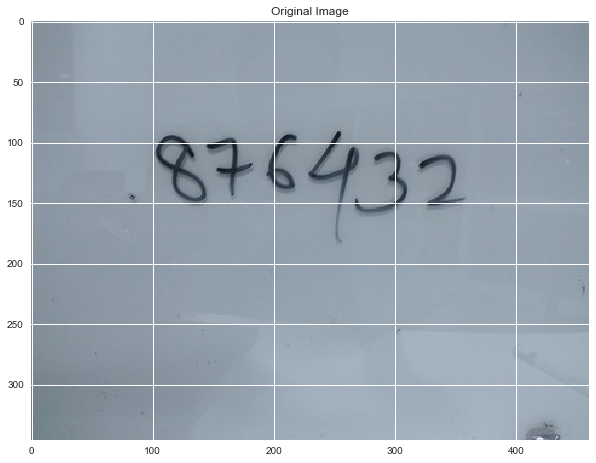

In [27]:
# read the input image 
im = cv2.imread(path+'imgs/digits1.jpg')
im_r = ndimage.rotate(im, -5)
plt.figure(figsize=(10, 10))
plt.imshow(im)
plt.title('Original Image')

# convert to grayscale and apply Gaussian filtering
im_gray = cv2.cvtColor(im_r, cv2.COLOR_BGR2GRAY)
im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)

# threshold the image
ret, im_th = cv2.threshold(im_gray, 90, 255, cv2.THRESH_BINARY_INV)

# find contours in the image
_, ctrs, hier = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# get rectangles contains each contour
rects = [cv2.boundingRect(ctr) for ctr in ctrs]

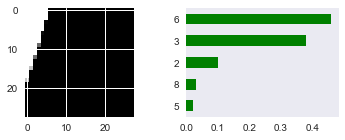

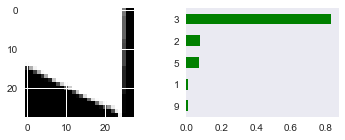

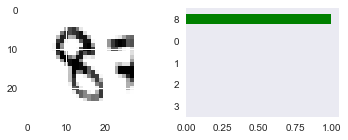

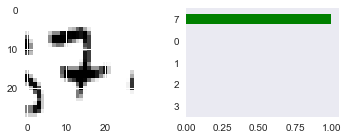

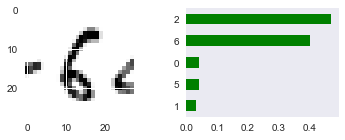

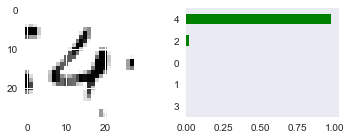

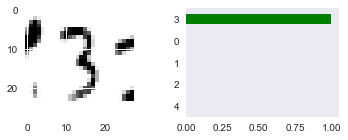

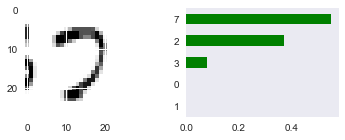

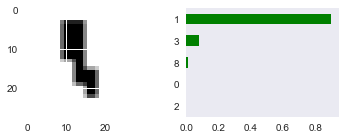

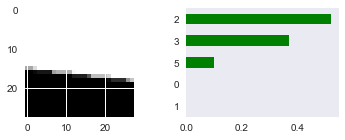

In [28]:
imgs = []
imgs_to_pred = []
for i, rect in enumerate(reversed(rects)):
    # make the rectangular region around the digit
    leng = int(rect[3]*1.6)
    pt1 = int(rect[1]+rect[3]//2-leng//2)
    pt2 = int(rect[0]+rect[2]//2-leng//2)
    roi = im_th[pt1:pt1+leng, pt2:pt2+leng]
    try:
        roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
        roi = cv2.dilate(roi, (3, 3))
        imgs.append(roi)
        imgs_to_pred.append(roi/255.)
    except:
        pass

imgs_to_pred = np.expand_dims(np.array(imgs_to_pred), axis=1).astype('float32')
preds = model.predict(imgs_to_pred)
for i in range(len(imgs)):
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(imgs[i])
    temp = pd.DataFrame(pd.Series(preds[i]).round(2))
    temp['index'] = temp.index
    temp.columns = ['proba', 'index']
    temp.sort_values(by='proba', ascending=False, inplace=True)
    plt.subplot(1, 2, 2)
    temp['proba'][:5].plot(kind='barh', color='green').invert_yaxis()
    plt.grid(False)